## Goal : Extract the evolution of the number of toggles per project

Import

In [42]:
import os
import regex as re
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pat
from matplotlib.ticker import ScalarFormatter
import json

### Now we can plot the number of feature toggles

In [49]:
months = dict()

writen_monthes = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for index_month in range(len(writen_monthes)):
    months[writen_monthes[index_month]] = index_month+1

# 1. we count the number of FT

def extract_nb_ft(file_path, exp):
    # input : a file path to a version of the feature toggle file
    # output : the number of feature toggles in the file
    with open(file_path, 'r') as f:
        m = re.findall(exp, f.read())
    return len(m)

# 2. we extract the date (usable as timestamp)

def extract_date(file_path):
    # input : the path of the file 
    # e.g. 0001.26-Oct-2021.46c1c24b48572d74fb582e1e5a62552c39409685.featureflag.go
    # output : the date "26-Oct-2021"
    return file_path.split(".")[3]

def extract_stamp(kf):
    # input : the path of the file 
    # e.g. 0001.26-Oct-2021.46c1c24b48572d74fb582e1e5a62552c39409685.featureflag.go
    # output : a timestamp
    d = extract_date(kf).split('-')
    # class datetime.date(year, month, day)
    return datetime.date(int(d[2]), months[d[1]], int(d[0]))

def get_dates_and_fts(system_name, exp):

    data_dir =  "../data/"+system_name+"_ft_changes/"

    files = [data_dir+k for k in os.listdir(data_dir)]
    
    df_ft = pd.DataFrame([[extract_stamp(kf) for kf in files], 
                      [extract_nb_ft(kf, exp) for kf in files]]).dropna().transpose()
    
    df_ft.columns = ["date", "ft"]
    
    df_ft = df_ft.sort_values(by=["date"])
    
    return df_ft

res = dict()
res['boulder'] = get_dates_and_fts('boulder', "\n([a-zA-Z]*)\n")
res['juju'] = get_dates_and_fts('juju', "const (.*) =")
res['kops'] = get_dates_and_fts('kops', "[N|n]ew.*,*Bool*")
res['kubernetes'] = get_dates_and_fts('kubernetes', "\n\t([a-zA-Z0-9])=")
res['loomchain'] = get_dates_and_fts('loomchain', "=")

#### Plot results

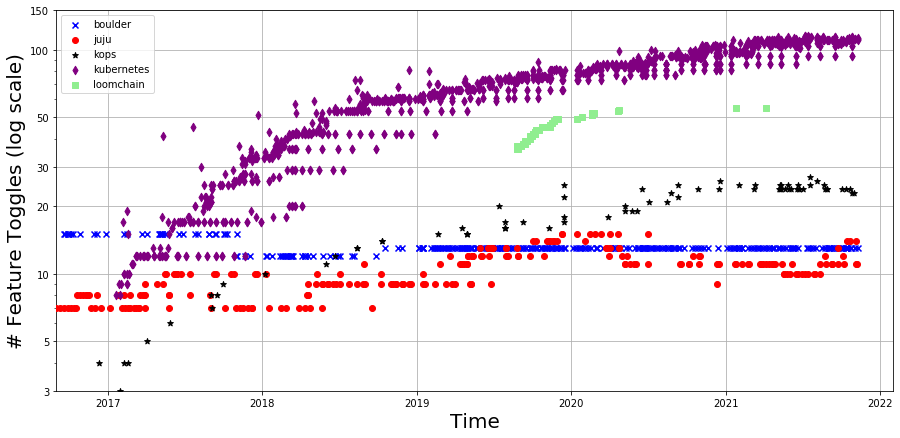

In [51]:
fig, ax = plt.subplots(figsize=((15, 7)))

plt.xlim(datetime.date(2016, 9, 1), datetime.date(2022, 2, 1))
plt.ylim(3, 100)

ax.grid(zorder = 0)

colors = ['blue', 'red', 'black', 'purple', 'lightgreen', 'grey']
markers = ["x", "o", "*", "d", "s"]

keys = [k for k in res.keys()]

for i in range(len(keys)):
    sys = keys[i]
    ax.scatter(res[sys].date, res[sys].ft, color = colors[i], marker= markers[i], zorder = 4, label = sys)

ax.set_yscale('log')
ax.get_yaxis().set_major_formatter(ScalarFormatter())
ax.set_yticks([3, 5, 10,20, 30, 50,100, 150])
plt.ylabel("# Feature Toggles (log scale)", size = 20)
plt.xlabel("Time", size = 20)
plt.legend()
plt.savefig("../results/evolution_fts.png", dpi = 300)
plt.show()